In [1]:
import numpy as np, numpy.random as npr, torch.nn as nn, copy, timeit, torch
from torch.distributions.bernoulli import Bernoulli 
from HMCfunctions import *
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import plot, show, legend

Gradient w.r.t. $\theta$:

$$
\nabla_\theta \log p(\theta \mid \sigma, x_{1:n}, y_{1:n}) 
= 
- \sum_{i=1}^n \frac{\left ( \mu_\theta(x_i) - y_i \right ) \, \nabla_\theta \mu_\theta(x_i) }{\sigma^{2k}} + \nabla_\theta \log p_0(\theta) 
$$

#### Set up neural network:

In [20]:
n_in = 1
# n_h1 = 5
# n_h2 = 10
n_out = 2

nn_model = nn.Sequential(nn.Linear(n_in, n_out))

* Total number of parameters:

In [21]:
print(sum(p.numel() for p in nn_model.parameters()))

4


* Randomly initialise model parameters:

In [22]:
nn_model.apply(init_normal)

Sequential(
  (0): Linear(in_features=1, out_features=2, bias=True)
)

#### Generate some random data:

In [44]:
nobs = 1_000
x = torch.rand(nobs, n_in)
y = np.zeros((nobs, n_out))
y[:,0] = list(np.cos(2*np.pi*x))
y[:,1] = list(np.sin(2*np.pi*x))
y = torch.from_numpy(y).float()
criterion = nn.MSELoss()

* Get dimensions of parameters:

In [45]:
shapes = get_shapes(nn_model)
print("Shapes = ", shapes)

Shapes =  [torch.Size([2, 1]), torch.Size([2])]


###  HMC

* First define the MCMC chain and randomly initialise it:

In [46]:
T = 2_000
chain = []
for shape in shapes :
    chain_shape = list(shape)
    chain_shape.insert(0,T)
    chain.append(torch.randn(chain_shape, requires_grad=False))

* Then run HMC:

In [53]:
delta_leapfrog = 0.1
n_leapfrog = 10
prior_sigma = 0.1
nn_model.apply(init_normal)
n_accept = 0

In [54]:
start_time = time()
for t in range(T) : 
    nn_model, a = HMC_1step(nn_model, n_leapfrog, delta_leapfrog, shapes, x, y, criterion, prior_sigma)
    n_accept += a
    update_grads(nn_model, x, y)
    for (i,param) in enumerate(nn_model.parameters()) :
        chain[i][t] = param.data
        
    if ((t+1) % 200 == 0) or (t+1) == T :
        accept_rate = float(n_accept) / float(t+1)
        print("iter %6d/%d after %7.1f sec | accept_rate %.3f" % (
            t+1, T, time() - start_time, accept_rate))

iter    200/2000 after     0.8 sec | accept_rate 0.595
iter    400/2000 after     1.5 sec | accept_rate 0.637
iter    600/2000 after     2.3 sec | accept_rate 0.620
iter    800/2000 after     3.1 sec | accept_rate 0.610
iter   1000/2000 after     3.8 sec | accept_rate 0.601
iter   1200/2000 after     4.6 sec | accept_rate 0.597
iter   1400/2000 after     5.4 sec | accept_rate 0.596
iter   1600/2000 after     6.2 sec | accept_rate 0.601
iter   1800/2000 after     7.0 sec | accept_rate 0.606
iter   2000/2000 after     7.8 sec | accept_rate 0.609


#### ESS's:

In [55]:
ESS, means, Vars = find_ESS(chain, shapes)

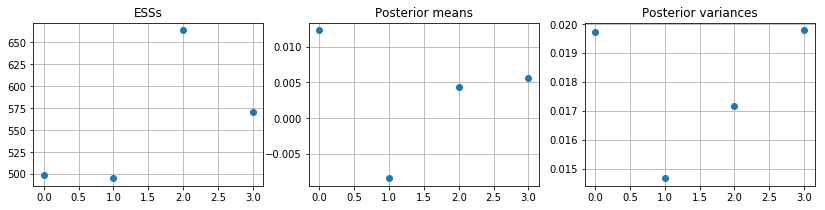

In [56]:
plt.figure(figsize=(14,3))
plt.rcParams['axes.grid'] = True
plt.subplot(131)
plt.plot(ESS, 'o', markersize=6)
plt.title("ESSs")
plt.subplot(132)
plt.plot(means, 'o', markersize=6)
plt.title("Posterior means")
plt.subplot(133)
plt.plot(Vars, 'o', markersize=6)
plt.title("Posterior variances");

#### Diagnostics:

In [29]:
for param in nn_model.parameters() :
    print(param.data)

tensor([[ 0.0568],
        [ 0.0717],
        [-0.1660],
        [ 0.1499],
        [ 0.0217]])
tensor([-0.0147, -0.1183,  0.1159,  0.2373,  0.0040])
tensor([[ 0.0592,  0.2783,  0.1133,  0.1754, -0.0465],
        [ 0.0093,  0.1470,  0.1040,  0.0175,  0.0557]])
tensor([ 0.2440, -0.0011])


In [36]:
mom = generate_momentum(shapes)
for (i, param) in enumerate(nn_model.parameters()) :
    print(param.grad)
    pos_change = delta_leapfrog*mom[i]
    param.data.add_(pos_change)

# update gradients based on new parameters (ie, new positions):
update_grads(nn_model, x, y)

tensor([[-0.0017],
        [ 0.1198],
        [-0.0413],
        [ 0.0180],
        [-0.0067]])
tensor([-0.0475,  0.0733, -0.0388,  0.0092,  0.0024])
tensor([[-0.1010,  0.0318, -0.0577,  0.1639, -0.0535],
        [ 0.0624,  0.0261, -0.0146, -0.1096,  0.0899]])
tensor([ 0.3493, -0.2647])


In [38]:
for param in nn_model.parameters() :
    print(param.grad, param.data)

tensor([[-0.0321],
        [ 0.1064],
        [-0.0384],
        [ 0.0445],
        [-0.0029]]) tensor([[-0.0915],
        [ 0.2873],
        [-0.3784],
        [ 0.0881],
        [ 0.2455]])
tensor([-0.1525,  0.0253, -0.0561,  0.0568, -0.0123]) tensor([-0.1196,  0.0579,  0.0866,  0.4649, -0.1564])
tensor([[-0.0682,  0.0867, -0.0500,  0.1908, -0.0080],
        [ 0.0589, -0.0412, -0.0202, -0.2018,  0.0588]]) tensor([[-0.0858,  0.6051, -0.1807,  0.2724, -0.0085],
        [ 0.2646,  0.4574, -0.0350,  0.0774,  0.0197]])
tensor([ 0.4032, -0.4566]) tensor([ 0.1545, -0.5320])


### SGD:

In [50]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.01)

In [52]:
for epoch in range(10_000):
    # Forward Propagation
    y_pred = nn_model(x)
    # Compute and print loss
    loss = criterion(y_pred, y)
    if (epoch+1)%1_000 == 0 :
        print('epoch: ', epoch+1,' loss: ', loss.item())
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

epoch:  1000  loss:  0.0023619267158210278
epoch:  2000  loss:  0.002133300295099616
epoch:  3000  loss:  0.0019551068544387817
epoch:  4000  loss:  0.0018106142524629831
epoch:  5000  loss:  0.0016899053007364273
epoch:  6000  loss:  0.0015869464259594679
epoch:  7000  loss:  0.0014977598330006003
epoch:  8000  loss:  0.0014195973053574562
epoch:  9000  loss:  0.0013503892114385962
epoch:  10000  loss:  0.0012886177282780409


In [53]:
for param in nn_model.parameters() :
    print(param.data)

tensor([[-2.1665],
        [-1.9729],
        [-1.5795],
        [ 0.8104],
        [ 0.2475],
        [ 1.0761],
        [-0.2389],
        [ 1.0297],
        [ 0.2333],
        [ 0.0546]])
tensor([-0.1743,  1.5218,  0.7305, -2.5212, -0.1287, -1.0229,  1.6127,  0.1791,
         1.3210,  1.9390])
tensor([[-1.4242,  1.8039,  2.0729, -1.1618, -1.8121,  0.8300, -0.0083,  0.6605,
         -0.0780,  0.0871],
        [-1.2430,  0.2569, -1.4725,  0.0772,  0.0847, -0.5737,  1.7772, -0.9373,
          0.7119, -1.9187],
        [-1.2904,  1.2443,  0.6092,  0.3899,  0.5008, -0.9106, -1.3703,  0.7291,
          0.4810, -1.0716],
        [-0.1107,  1.2203, -0.1692, -2.2403, -0.3955, -0.6435,  1.0898,  0.9260,
         -0.2731, -0.2194],
        [ 0.0799,  0.2410, -0.2684, -2.2200,  1.0859,  0.6179, -0.7963,  0.1474,
         -0.0139,  0.8258],
        [ 0.1763, -0.6303, -3.8560,  1.2778,  0.1500, -0.9534,  0.3163, -0.2852,
         -0.1199,  1.8668],
        [-0.4545,  0.2751,  0.1255, -0.9237, -0.